<a href="https://www.kaggle.com/code/averma111/pss3e17-binary-classification-pytorch?scriptVersionId=133727891" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [10]:
import numpy as np 
import pandas as pd 
import os
import datetime
import seaborn as sns

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,Dataset
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [6]:
class GenericPytorch(object):
    
    def __init__(self,model,loss_fun,optimizer):
        self.model = model
        self.loss_fun = loss_fun 
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        
        ## Placeholders 
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        #Variables 
        self.losses =[]
        self.val_losses = []
        self.total_epoch = 0
        
        #Helper Function
        self.train_step_fun = self._make_train_step_fun()
        self.val_step_fun = self._make_val_step_fun()
        
    def to(self,device):
        try:
            self.device = device
            self.model.to(self.device)
            
        except RuntimeError:
            self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
            print(f'Could not send it {device}, sending it to {self.device} instead')
            self.model.to(self.device)
            
    
    def set_loaders(self,train_loader,val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        
    def set_tesnorboard(self,name,folder='runs'):
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')
        
    def _make_step_train_fun(self):
        
        def perform_train_step_fun(X,y):
            # Set the model to train 
            self.mode.train()
            #Step 1 - Forward pass / make  predictions
            yhat = self.model(X)
            #Step 2 - Compute loss 
            loss = self.loss_fun(yhat,y)
            #Step 3 - Compute the gradients
            loss.backward()
            #Step 4 - Update the variables and set the gradient to 0
            self.optimizer.step()
            self.optimizer.zoro_grad()
            
            return loss.item()
        
        return perform_train_step_fun
            
    
    def _make_step_val_fun(self):
        
        def perform_val_step_fun(X):
            # Set the model to train 
            self.mode.eval()
            #Step 1 - Forward pass / make  predictions
            yhat = self.model(X)
            #Step 2 - Compute loss 
            loss = self.loss_fun(yhat,y)
            
            return loss.item()
        
        return perform_val_step_fun
    
    
    def _mini_batch(self,validation=False):
        
        if validation:
            data_loader = self.val_loader
            step_fun = self.val_step_fun
        else:
            data_loader = self.train_loader
            step_fun = self.train_loader
        
        if data_loader is None:
            return None
        
        # Loop mini-batch 
        mini_batch_losses =[] 
        
        for x_batch,y_batch  in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            mini_batch_loss = step_fun(x_batch,y_batch)
            mini_batch_losses.append(mini_batch_loss)
            
        loss = np.mean(mini_batch_losses)
        
        return loss
    
    def set_seed(self,seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    
    def train(self,n_epochs,seed=42):
        #Reproducibility
        self.set_seed(seed)
        
        for epoch in range(n_epochs):
            self.total_epoch +=1
            
            #inner loop perform training using mini_batch
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
            
            #Validation 
            with torch.no_grad():
                #Perform evaluation using mini-batch
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
                
            #SummaryWriter 
            if self.writer:
                scalars ={
                    'training':loss}
                if val_loss is not None:
                    scalars.update({'validation':val_loss})
                    
                #Record both losses for each epoch
                self.writer.add_scalars(main_tag='loss',tag_scalar_dict=scalars,global_step=epoch)
                
                
        if self.writer:
            #Flush the writer 
            self.writer.flush()
        
    
    def save_checkpoint(self,filename):
        #Build the dictionary with all the elements for resuming training
        checkpoint = {
            'epoch':self.total_epoch,
            'model_state_dict':self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
        
        torch.save(checkpoint,filename)
        
    
    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))
        
        
        
    
        

In [7]:
class CustomDataset(Dataset):
    
    def __init__(self,X_train,y_train=None,is_train=True):
        super().__init__()
        if is_train:
            self.X_train = X_train
            self.y_train = y_train
        else:
            self.X_train=X_train
            
    def __getitem__(self,index):
        return (self.X_train[index],self.y_train[index])
    
    def __len__(self):
        return len(self.X_train)
        
        
    

In [8]:
class Datapreparation(object):
    
    def __init__(self,root_path):
        self.root_path = root_path
        
    def get_dataframe(self,filename):
        return pd.read_csv(os.path.join(self.root_path,filename))
    
    def summary(self,text, df):
        summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summary['null'] = df.isnull().sum()
        summary['unique'] = df.nunique()
        summary['min'] = df.min()
        summary['median'] = df.median()
        summary['max'] = df.max()
        summary['mean'] = df.mean()
        summary['std'] = df.std()
        summary['duplicate'] = df.duplicated().sum()
        return summary
    
    def rename_column(self,df):
        updated_df=df.rename(columns=
                             {"Product ID": "Product_ID", 
                              "Air temperature [K]": "Air_temperature",
                             "Process temperature [K]":"Process_temperature",
                             "Rotational speed [rpm]":"Rotational_speed",
                             "Torque [Nm]":"Torque",
                             "Tool wear [min]":"Tool_wear",
                             "Machine failure":"Machine_failure"}
                            )
        return updated_df
    
    
    

    
data = Datapreparation('/kaggle/input/playground-series-s3e17')
train=data.get_dataframe('train.csv')
train = data.rename_column(train)
data.summary('train',train)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,136429,0,68214.0,136428,68214.000000,39383.804275,0
Product_ID,object,0,9976,H29424,NaN,M24859,NaN,NaN,0
Type,object,0,3,H,NaN,M,NaN,NaN,0
Air_temperature,float64,0,95,295.3,300.0,304.4,299.862776,1.862247,0
Process_temperature,float64,0,81,305.8,310.0,313.8,309.941070,1.385173,0
Rotational_speed,int64,0,952,1181,1493.0,2886,1520.331110,138.736632,0
Torque,float64,0,611,3.8,40.4,76.6,40.348643,8.502229,0
Tool_wear,int64,0,246,0,106.0,253,104.408901,63.965040,0
Machine_failure,int64,0,2,0,0.0,1,0.015744,0.124486,0
TWF,int64,0,2,0,0.0,1,0.001554,0.039389,0


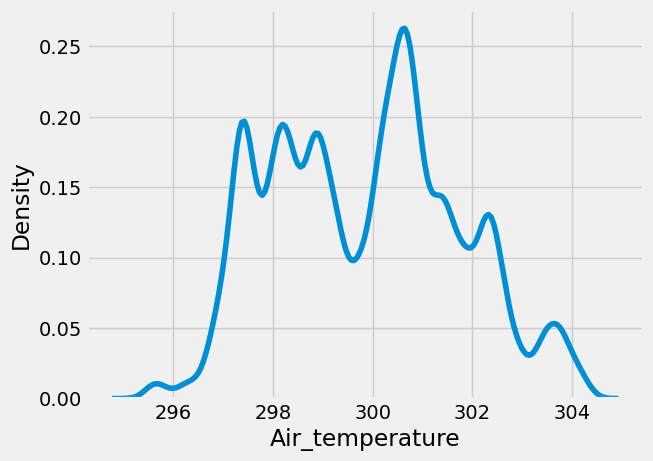

In [19]:
class Plotdata(object):
    
    def plot_kde_data(self,df,field):
        sns.kdeplot(data=df[field])
 
plot = Plotdata()
plot.plot_kde_data(train,'Air_temperature')

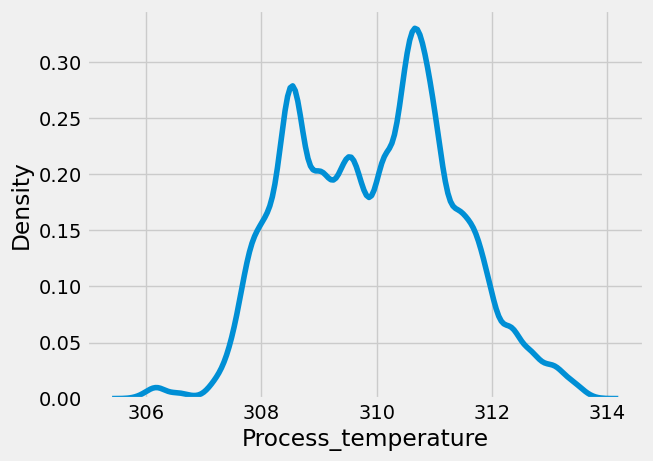

In [21]:
plot.plot_kde_data(train,'Process_temperature')

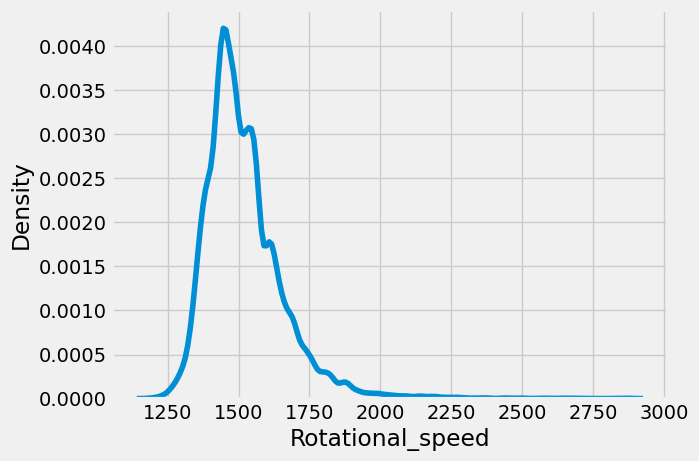

In [22]:
plot.plot_kde_data(train,'Rotational_speed')

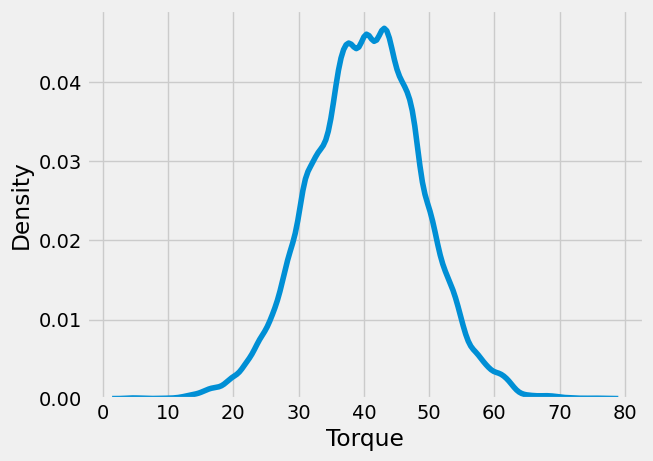

In [23]:
plot.plot_kde_data(train,'Torque')

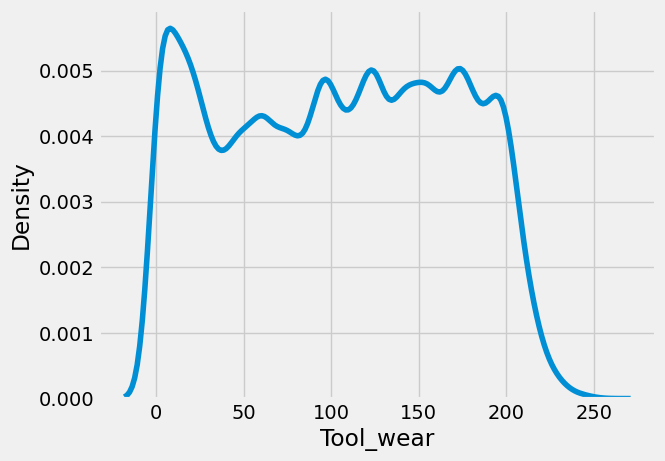

In [24]:
plot.plot_kde_data(train,'Tool_wear')